In [ ]:
#pip install scikit-image

In [337]:
import pandas as pd
import pyarrow.parquet as pq
import numpy as np
from tqdm import tqdm
import time
import random
import os
from glob import glob
from PIL import Image
from PIL import Image, ImageDraw
import cv2
import matplotlib.pyplot as plt
import warnings; warnings.filterwarnings('ignore')

from sklearn.metrics import mean_absolute_error
from sklearn.model_selection import train_test_split

import torch
from torch import nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
from torch.utils.data import random_split
import torchvision.transforms as transforms
from torchvision import utils
import torch.optim as optim
from torch.optim import Adam
import torch.nn.init as init
import torchvision.transforms.functional as TF

import nibabel as nib  # to read NIFTI file
from sklearn.model_selection import KFold, StratifiedKFold
from nibabel.testing import data_path
import tempfile
import seaborn as sns
import pydicom as dicom
import pandas as pd
import pyarrow.parquet as pq
import numpy as np
from tqdm import tqdm
import time
import random
import os
from PIL import Image
from PIL import Image, ImageDraw
import cv2
import matplotlib.pyplot as plt
import warnings; warnings.filterwarnings('ignore')

import timm 
from skimage.transform import rotate
from sklearn.metrics import mean_absolute_error
from sklearn.model_selection import train_test_split

import torch
from torch import nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
from torch.utils.data import random_split
import torchvision.transforms as transforms
from torchvision import utils
import torch.optim as optim
from torch.optim import Adam
import torch.nn.init as init
import torchvision.transforms.functional as TF

import segmentation_models_pytorch as smp
from monai.transforms import Resize
import  monai.transforms as transforms

### Settings

In [2]:
segfile_dir = "./segmentations"
trainfile_dir = "./train_images"

model_dir = "./model"

image_sizes = [128 , 128, 128] 

### Dataframe 

In [3]:
train_df = pd.read_csv('train.csv') 
train_series_meta_df = pd.read_csv('train_series_meta.csv')
test_series_meta_df = pd.read_csv('test_series_meta.csv')
image_level_labels_df = pd.read_csv('image_level_labels.csv')
sample_submission_df = pd.read_csv('sample_submission.csv')

In [4]:
sample_submission_df

,patient_id,bowel_healthy,bowel_injury,extravasation_healthy,extravasation_injury,kidney_healthy,kidney_low,kidney_high,liver_healthy,liver_low,liver_high,spleen_healthy,spleen_low,spleen_high
0,48843,0.5,0.5,0.5,0.5,0.333333,0.333333,0.333333,0.333333,0.333333,0.333333,0.333333,0.333333,0.333333
1,50046,0.5,0.5,0.5,0.5,0.333333,0.333333,0.333333,0.333333,0.333333,0.333333,0.333333,0.333333,0.333333
2,63706,0.5,0.5,0.5,0.5,0.333333,0.333333,0.333333,0.333333,0.333333,0.333333,0.333333,0.333333,0.333333


In [5]:
print(train_df.shape)
train_df.head()

(3147, 15)


,patient_id,bowel_healthy,bowel_injury,extravasation_healthy,extravasation_injury,kidney_healthy,kidney_low,kidney_high,liver_healthy,liver_low,liver_high,spleen_healthy,spleen_low,spleen_high,any_injury
0,10004,1,0,0,1,0,1,0,1,0,0,0,0,1,1
1,10005,1,0,1,0,1,0,0,1,0,0,1,0,0,0
2,10007,1,0,1,0,1,0,0,1,0,0,1,0,0,0
3,10026,1,0,1,0,1,0,0,1,0,0,1,0,0,0
4,10051,1,0,1,0,1,0,0,1,0,0,0,1,0,1


In [6]:
print(train_series_meta_df.shape)
train_series_meta_df.head()

(4711, 4)


,patient_id,series_id,aortic_hu,incomplete_organ
0,10004,21057,146.00,0
1,10004,51033,454.75,0
2,10005,18667,187.00,0
3,10007,47578,329.00,0
4,10026,29700,327.00,0


In [7]:
#series_id is unique 
train_series_meta_df.duplicated(subset=['series_id']).any()

False

In [394]:
train_df.loc[train_df['patient_id'] == 34409]

,patient_id,bowel_healthy,bowel_injury,extravasation_healthy,extravasation_injury,kidney_healthy,kidney_low,kidney_high,liver_healthy,liver_low,liver_high,spleen_healthy,spleen_low,spleen_high,any_injury
1339,34409,1,0,1,0,1,0,0,0,0,1,0,1,0,1


In [ ]:
train_series_meta_df.loc[train_series_meta_df['series_id'] == 778]

In [9]:
#find all train_images and retrive their series_id
train_images_files = os.listdir('./train_images')
train_images_file_series_id = []
p_series_id_dict = {}
for pid in train_images_files:
    for s in os.listdir('./train_images'+'/'+pid):
        train_images_file_series_id.append(int(s))
        p_series_id_dict[int(s)] = pid
train_images_df = pd.DataFrame({'series_id': train_images_file_series_id})
train_images_df['patient_id'] = train_images_df['series_id'].apply(lambda x:p_series_id_dict[x])
train_images_df['train_img_file_path'] = train_images_df['series_id'].apply(lambda x: trainfile_dir+"/"+str(p_series_id_dict[x])+"/"+ str(x)+"/*")
train_images_df

,series_id,patient_id,train_img_file_path
0,21057,10004,./train_images/10004/21057/*
1,51033,10004,./train_images/10004/51033/*
2,18667,10005,./train_images/10005/18667/*
3,47578,10007,./train_images/10007/47578/*
4,29700,10026,./train_images/10026/29700/*
...,...,...,...
4288,34551,65508,./train_images/65508/34551/*
4289,778,7642,./train_images/7642/778/*
4290,41663,8848,./train_images/8848/41663/*
4291,7384,8848,./train_images/8848/7384/*


In [10]:
#find all segmentation files
segments = os.listdir('./segmentations')
segments_images_df = pd.DataFrame({'seg_files': segments})
segments_images_df['series_id'] = segments_images_df['seg_files'].apply(lambda x: int(x[:-4]))
segments_images_df['seg_img_file_path'] = segments_images_df['seg_files'].apply(lambda x: segfile_dir+"/"+ x)
del segments_images_df['seg_files']
print(segments_images_df.shape)
segments_images_df.head()

(206, 2)


,series_id,seg_img_file_path
0,10000,./segmentations/10000.nii
1,10109,./segmentations/10109.nii
2,10180,./segmentations/10180.nii
3,10252,./segmentations/10252.nii
4,10385,./segmentations/10385.nii


In [11]:
seg_train_df = segments_images_df.merge(train_images_df, on='series_id', how='left')
seg_train_df

,series_id,seg_img_file_path,patient_id,train_img_file_path
0,10000,./segmentations/10000.nii,54722,./train_images/54722/10000/*
1,10109,./segmentations/10109.nii,48710,./train_images/48710/10109/*
2,10180,./segmentations/10180.nii,62116,./train_images/62116/10180/*
3,10252,./segmentations/10252.nii,34409,./train_images/34409/10252/*
4,10385,./segmentations/10385.nii,28925,./train_images/28925/10385/*
...,...,...,...,...
201,7818,./segmentations/7818.nii,58729,./train_images/58729/7818/*
202,8236,./segmentations/8236.nii,4093,./train_images/4093/8236/*
203,8320,./segmentations/8320.nii,39330,./train_images/39330/8320/*
204,8340,./segmentations/8340.nii,38982,./train_images/38982/8340/*


In [12]:
#k-fold cross validation 
kf = KFold(n_splits=10, shuffle=True)

for i, (_, v_ind) in enumerate(kf.split(seg_train_df)):
    seg_train_df.loc[seg_train_df.index[v_ind], 'kfold'] = i
print(seg_train_df.to_string())

     series_id          seg_img_file_path patient_id           train_img_file_path  kfold
0        10000  ./segmentations/10000.nii      54722  ./train_images/54722/10000/*    7.0
1        10109  ./segmentations/10109.nii      48710  ./train_images/48710/10109/*    0.0
2        10180  ./segmentations/10180.nii      62116  ./train_images/62116/10180/*    5.0
3        10252  ./segmentations/10252.nii      34409  ./train_images/34409/10252/*    2.0
4        10385  ./segmentations/10385.nii      28925  ./train_images/28925/10385/*    2.0
5        10494  ./segmentations/10494.nii      60744  ./train_images/60744/10494/*    6.0
6        11748  ./segmentations/11748.nii      42436  ./train_images/42436/11748/*    3.0
7         1201   ./segmentations/1201.nii      50518   ./train_images/50518/1201/*    9.0
8        12039  ./segmentations/12039.nii      10937  ./train_images/10937/12039/*    0.0
9        12102  ./segmentations/12102.nii      64256  ./train_images/64256/12102/*    2.0
10       1

In [13]:
#count number of dicom images per series_id
img_num_per_series_id = pd.DataFrame()
img_num_per_series_id['num_of_dicom_images'] = seg_train_df['train_img_file_path'].apply(lambda x: len(os.listdir(x[0:-1])))
img_num_per_series_id.describe()

,num_of_dicom_images
count,206.000000
mean,342.432039
std,228.774535
min,47.000000
25%,180.250000
50%,254.000000
75%,482.500000
max,1044.000000


<AxesSubplot:ylabel='Frequency'>

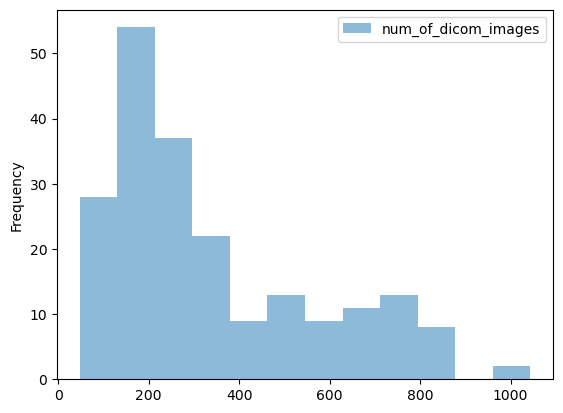

In [14]:
ax = img_num_per_series_id.plot.hist(bins=12, alpha=0.5)
ax

### Data Set

In [15]:
#TODO: 
img_transform = transforms.Compose([
                        transforms.Resize((128,128)),
                        transforms.RandomHorizontalFlip(p=0.5),
                        ])

In [432]:
def norm_img(imgs):
    imgs = imgs - np.min(imgs)
    imgs = imgs / (np.max(imgs) + 1e-4)
    imgs = (imgs * 255).astype(np.uint8)
    return imgs


def load_dicom(train_img_file_path):
    train_images_glob = glob(train_img_file_path)
    #sort images into ascending order 
    train_images_glob = sorted(train_images_glob,key=lambda x: int(x.split('\\')[-1].split('.dcm')[0]))  
    selected_z_indices = np.quantile(list(range(len(train_images_glob))), np.linspace(0., 1., image_sizes[2])).round().astype(int)
    imgs = []

    for i in selected_z_indices:
        img_path = train_images_glob[i]
        img = dicom.dcmread(img_path).pixel_array 
        img_resized = cv2.resize(img, (image_sizes[0], image_sizes[1]), interpolation = cv2.INTER_LINEAR)    
        imgs.append(img_resized)
    # DO DICOM IMG PRE-PROCESSING HERE

    imgs = np.array(imgs)
    imgs = np.stack(imgs, -1)
    #normalize the images
    imgs = norm_img(imgs)

    return imgs
    

def load_seg_nii(path):
    #https://nipy.org/nibabel/nibabel_images.html
    img = nib.load(path).get_fdata()
    img = img.transpose(1, 0, 2)[::-1, :, ::-1]  

    #print(img[0])
    #print(img[:,:,0])
    shape = img.shape

    
    mask = np.zeros((5, shape[0], shape[1], shape[2]))
    
    for cid in range(1):
        mask[cid] = (img == (cid+1))

    #img = cv2.resize(img[:,:,1 + 0], (image_sizes[0], image_sizes[1]), interpolation = cv2.INTER_LINEAR)  
    #i1 = rotate(img, -90)
    #i1 = cv2.flip(i1, 1)
    mask = mask.astype(np.uint8) * 255
    
    #doc: https://docs.monai.io/en/stable/transforms.html
    print("ori size")
    print(mask.shape)
    mask = Resize(spatial_size=(128,128,128))(mask)
    print(mask.shape)
    return norm_img(mask)

    

class SEGDataset(Dataset):
    
    def __init__(self, dataframe, transform):
        self.df = dataframe
        self.transform = transform

    def __len__(self):
        return self.df.shape[0]
    
    def __getitem__(self, i):
        row = self.df.iloc[i]
        train_img_file_path = row['train_img_file_path']
        seg_img_file_path = row['seg_img_file_path']
        img = load_dicom(train_img_file_path)
        mask = load_seg_nii(seg_img_file_path)
        return img, mask 
        #train_images_glob = glob(train_img_file_path)
        #train_dicom_img = dicom.read_file(train_img_file_path)
        #seg_nii_img =  
        


In [393]:
seg_train_df.iloc[3]

series_id                                     10252
seg_img_file_path         ./segmentations/10252.nii
patient_id                                    34409
train_img_file_path    ./train_images/34409/10252/*
kfold                                           2.0
Name: 3, dtype: object

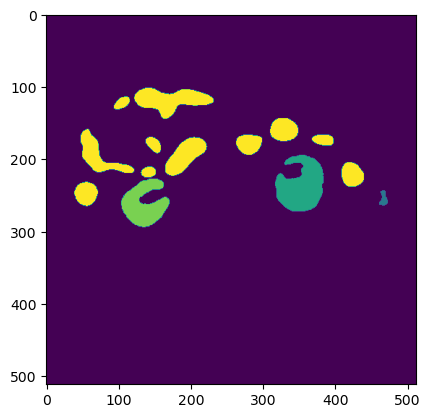

In [427]:
img = nib.load(seg_train_df.iloc[2]['seg_img_file_path']).get_fdata()
unique, counts = np.unique(img, return_counts=True)
img = img.transpose(1, 0, 2) 
img = img[::-1,:,:-1]

#img = cv2.resize(img[:,:,1 + 0], (image_sizes[0], image_sizes[1]), interpolation = cv2.INTER_LINEAR)  
#img = rotate(img, -90)
#img = cv2.flip(img, 1)
plt.imshow(img[:,:, 50]) 
plt.show()

In [ ]:
512,512,800

In [280]:
print(np.asarray((unique, counts)).T)
'''
[[0.00000000e+00 1.99012101e+08]
 [1.00000000e+00 7.06734600e+06]
 [2.00000000e+00 3.88596000e+06]
 [3.00000000e+00 8.42639000e+05]
 [4.00000000e+00 6.77537000e+05]
 [5.00000000e+00 5.56964900e+06]]
'''

[[0.00000000e+00 1.99012101e+08]
 [1.00000000e+00 7.06734600e+06]
 [2.00000000e+00 3.88596000e+06]
 [3.00000000e+00 8.42639000e+05]
 [4.00000000e+00 6.77537000e+05]
 [5.00000000e+00 5.56964900e+06]]


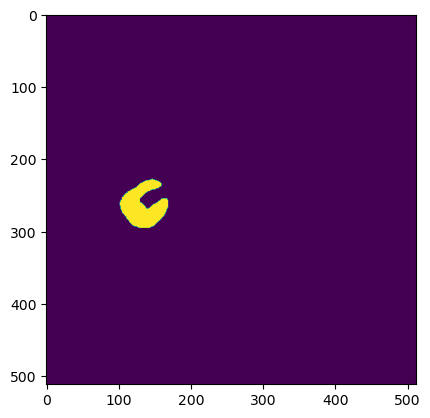

In [431]:
iimg = (img[:,:, 60]==4)
plt.imshow(iimg) 
plt.show()
#with np.printoptions(threshold=np.inf):
#    print(img)
#print(img.to_string())

In [433]:
i0 = load_seg_nii(seg_train_df.iloc[2]['seg_img_file_path'])
print(i0.shape)

ori size
(5, 512, 512, 828)
(5, 512, 512, 828)
(5, 512, 512, 828)


In [381]:
seg_train_df.iloc[2]

series_id                                     10180
seg_img_file_path         ./segmentations/10180.nii
patient_id                                    62116
train_img_file_path    ./train_images/62116/10180/*
kfold                                           5.0
Name: 2, dtype: object

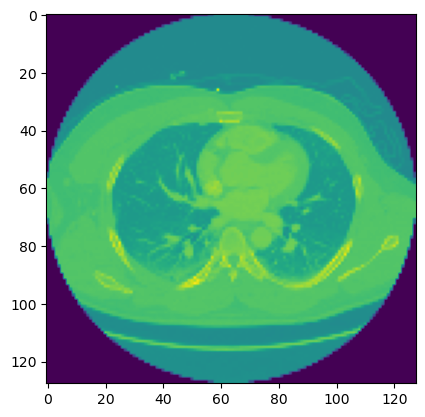

In [420]:
#sample dicom
i3 = load_dicom(seg_train_df.iloc[3]['train_img_file_path'])
o = i3[:,:,1]
plt.imshow(o)
plt.show()

In [193]:
# verticle rotate the matrix 
#a = np.array([[[1,2,3],[4,5,6]],   [[7,8,9],[10,11,12]] ])
#a = np.stack(a, -1)
#print(a[:,:,0])

[[1 2 3]
 [4 5 6]]


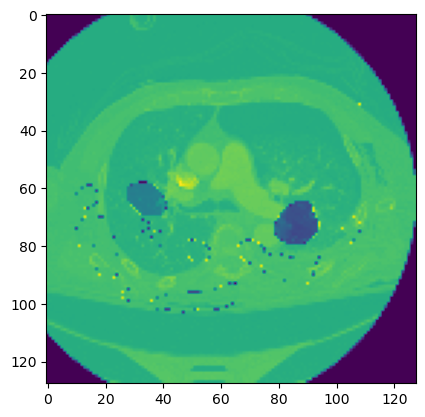

In [367]:
o =  cv2.resize(i1, (image_sizes[0], image_sizes[1]), interpolation = cv2.INTER_LINEAR)  
o = norm_img(o) + norm_img(i3[:,:,1])
#o  += i1     #i3[:,:,1]
plt.imshow(o)
plt.show()

In [435]:
seg_train_dataset = SEGDataset(seg_train_df,img_transform)


### Model

In [ ]:
#use resnet or other 3D Semantic Segmentation models 

#References 
#https://paperswithcode.com/task/3d-semantic-segmentation

#NN: Encoder & Decoder 
'''
In general sequence-to-sequence problems like machine translation, inputs and outputs are of varying lengths that are unaligned. 
The standard approach to handling this sort of data is to design an encoder–decoder architecture consisting of two major components: 
an encoder that takes a variable-length sequence as input, and a decoder that acts as a conditional language model, 
taking in the encoded input and the leftwards context of the target sequence and predicting the subsequent token in the target sequence.

Module: timm   https://github.com/huggingface/pytorch-image-models
        OR torchVision? https://pytorch.org/vision/main/models/generated/torchvision.models.resnet18.html
Encoder: ResNet "resnet18d"    
Decoder: U-Net
Segmentation_Head? nn.Conv2d
'''
#https://d2l.ai/chapter_recurrent-modern/encoder-decoder.html

In [338]:
class SegNNModel(nn.Module):
    def __init__(self):
        super(SegNNModel, self).__init__()
        #?
        n_blocks = 4 
        #doc: https://timm.fast.ai/create_model
        self.encoder = timm.create_model(
            "resnet50d",
            in_chans = 3,
            features_only = True, ######
            pretrained=False,
            drop_rate = 0
        )
        
        g = self.encoder(torch.rand(1, 3, 64, 64))
        #print(g.shape[1])
        
        '''
        torch.Size([1, 64, 32, 32])
        torch.Size([1, 256, 16, 16])
        torch.Size([1, 512, 8, 8])
        torch.Size([1, 1024, 4, 4])
        torch.Size([1, 2048, 2, 2])
        64 256 512 1024 2048 
        '''
        encoder_channels = [1] + [_.shape[1] for _ in g]
        decoder_channels = [256, 128, 64, 32, 16]

        #example : https://smp.readthedocs.io/en/v0.1.3/_modules/segmentation_models_pytorch/unet/model.html
        #blocks->depth of the unet
        self.decoder = smp.unet.decoder.UnetDecoder(
                encoder_channels=encoder_channels[:n_blocks+1],
                decoder_channels=decoder_channels[:n_blocks],
                n_blocks=n_blocks,
            )
        out_dim = 5 #features 
        self.segmentation_head = nn.Conv2d(decoder_channels[n_blocks-1], out_dim, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))

    
    def forward(self,x):

        global_features = [0] + self.encoder(x)[:n_blocks]
        seg_features = self.decoder(*global_features)
        seg_features = self.segmentation_head(seg_features)

In [343]:
from timm.models.layers.conv2d_same import Conv2dSame
from conv3d_same import Conv3dSame


def convert_3d(module):

    module_output = module
    if isinstance(module, torch.nn.BatchNorm2d):
        module_output = torch.nn.BatchNorm3d(
            module.num_features,
            module.eps,
            module.momentum,
            module.affine,
            module.track_running_stats,
        )
        if module.affine:
            with torch.no_grad():
                module_output.weight = module.weight
                module_output.bias = module.bias
        module_output.running_mean = module.running_mean
        module_output.running_var = module.running_var
        module_output.num_batches_tracked = module.num_batches_tracked
        if hasattr(module, "qconfig"):
            module_output.qconfig = module.qconfig
            
    elif isinstance(module, Conv2dSame):
        module_output = Conv3dSame(
            in_channels=module.in_channels,
            out_channels=module.out_channels,
            kernel_size=module.kernel_size[0],
            stride=module.stride[0],
            padding=module.padding[0],
            dilation=module.dilation[0],
            groups=module.groups,
            bias=module.bias is not None,
        )
        module_output.weight = torch.nn.Parameter(module.weight.unsqueeze(-1).repeat(1,1,1,1,module.kernel_size[0]))

    elif isinstance(module, torch.nn.Conv2d):
        module_output = torch.nn.Conv3d(
            in_channels=module.in_channels,
            out_channels=module.out_channels,
            kernel_size=module.kernel_size[0],
            stride=module.stride[0],
            padding=module.padding[0],
            dilation=module.dilation[0],
            groups=module.groups,
            bias=module.bias is not None,
            padding_mode=module.padding_mode
        )
        module_output.weight = torch.nn.Parameter(module.weight.unsqueeze(-1).repeat(1,1,1,1,module.kernel_size[0]))

    elif isinstance(module, torch.nn.MaxPool2d):
        module_output = torch.nn.MaxPool3d(
            kernel_size=module.kernel_size,
            stride=module.stride,
            padding=module.padding,
            dilation=module.dilation,
            ceil_mode=module.ceil_mode,
        )
    elif isinstance(module, torch.nn.AvgPool2d):
        module_output = torch.nn.AvgPool3d(
            kernel_size=module.kernel_size,
            stride=module.stride,
            padding=module.padding,
            ceil_mode=module.ceil_mode,
        )

    for name, child in module.named_children():
        module_output.add_module(
            name, convert_3d(child)
        )
    del module

    return module_output

In [341]:
#display layers of the network 
#m = SegNNModel()
#for name, child in m.named_children():
#    print(name,child)

encoder FeatureListNet(
  (conv1): Sequential(
    (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
    (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (4): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU(inplace=True)
    (6): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
  )
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (act1): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (act1): ReLU(inplace=True)
 

### Train

In [345]:
from typing import Any, Dict, Optional

loss_weights = [1, 1]
def binary_dice_score(
    y_pred: torch.Tensor,
    y_true: torch.Tensor,
    threshold: Optional[float] = None,
    nan_score_on_empty=False,
    eps: float = 1e-7,
) -> float:

    if threshold is not None:
        y_pred = (y_pred > threshold).to(y_true.dtype)

    intersection = torch.sum(y_pred * y_true).item()
    cardinality = (torch.sum(y_pred) + torch.sum(y_true)).item()

    score = (2.0 * intersection) / (cardinality + eps)

    has_targets = torch.sum(y_true) > 0
    has_predicted = torch.sum(y_pred) > 0

    if not has_targets:
        if nan_score_on_empty:
            score = np.nan
        else:
            score = float(not has_predicted)
    return score


def multilabel_dice_score(
    y_true: torch.Tensor,
    y_pred: torch.Tensor,
    threshold=None,
    eps=1e-7,
    nan_score_on_empty=False,
):
    ious = []
    num_classes = y_pred.size(0)
    for class_index in range(num_classes):
        iou = binary_dice_score(
            y_pred=y_pred[class_index],
            y_true=y_true[class_index],
            threshold=threshold,
            nan_score_on_empty=nan_score_on_empty,
            eps=eps,
        )
        ious.append(iou)

    return ious


def dice_loss(input, target):
    input = torch.sigmoid(input)
    smooth = 1.0
    iflat = input.view(-1)
    tflat = target.view(-1)
    intersection = (iflat * tflat).sum()
    return 1 - ((2.0 * intersection + smooth) / (iflat.sum() + tflat.sum() + smooth))


def bce_dice(input, target, loss_weights=loss_weights):
    loss1 = loss_weights[0] * nn.BCEWithLogitsLoss()(input, target)
    loss2 = loss_weights[1] * dice_loss(input, target)
    return (loss1 + loss2) / sum(loss_weights)

criterion = bce_dice

In [346]:
def mixup(input, truth, clip=[0, 1]):
    indices = torch.randperm(input.size(0))
    shuffled_input = input[indices]
    shuffled_labels = truth[indices]

    lam = np.random.uniform(clip[0], clip[1])
    input = input * lam + shuffled_input * (1 - lam)
    return input, truth, shuffled_labels, lam


def train_func(model, loader_train, optimizer, scaler=None):
    model.train()
    train_loss = []
    bar = tqdm(loader_train)
    for images, gt_masks in bar:
        optimizer.zero_grad()
        images = images.cuda()
        gt_masks = gt_masks.cuda()

        do_mixup = False
        if random.random() < p_mixup:
            do_mixup = True
            images, gt_masks, gt_masks_sfl, lam = mixup(images, gt_masks)

        with amp.autocast():
            logits = model(images)
            loss = criterion(logits, gt_masks)
            if do_mixup:
                loss2 = criterion(logits, gt_masks_sfl)
                loss = loss * lam  + loss2 * (1 - lam)

        train_loss.append(loss.item())
        scaler.scale(loss).backward()
        scaler.step(optimizer)
        scaler.update()

        bar.set_description(f'smth:{np.mean(train_loss[-30:]):.4f}')

    return np.mean(train_loss)


def valid_func(model, loader_valid):
    model.eval()
    valid_loss = []
    outputs = []
    ths = [0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8]
    batch_metrics = [[]] * 7
    bar = tqdm(loader_valid)
    with torch.no_grad():
        for images, gt_masks in bar:
            images = images.cuda()
            gt_masks = gt_masks.cuda()

            logits = model(images)
            loss = criterion(logits, gt_masks)
            valid_loss.append(loss.item())
            for thi, th in enumerate(ths):
                pred = (logits.sigmoid() > th).float().detach()
                for i in range(logits.shape[0]):
                    tmp = multilabel_dice_score(
                        y_pred=logits[i].sigmoid().cpu(),
                        y_true=gt_masks[i].cpu(),
                        threshold=0.5,
                    )
                    batch_metrics[thi].extend(tmp)
            bar.set_description(f'smth:{np.mean(valid_loss[-30:]):.4f}')
            
    metrics = [np.mean(this_metric) for this_metric in batch_metrics]
    print('best th:', ths[np.argmax(metrics)], 'best dc:', np.max(metrics))

    return np.mean(valid_loss), np.max(metrics)

In [333]:
#TENSOR = torch.tensor([[[1, 2, 3],
                        [3, 6, 9],
                        [2, 4, 5]]])
#TENSOR.shape


torch.Size([1, 3, 3])

In [339]:
model = SegNNModel()